<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/02142.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 7.3 小批量随机梯度下降

### 7.3.1 读取数据

In [0]:
%matplotlib inline 
import numpy as np 
import torch 
from torch import nn, optim 
import d2l 
import time 

In [0]:
!mkdir ../../data 

In [4]:
!git clone https://github.com/ShusenTang/Dive-into-DL-PyTorch.git

Cloning into 'Dive-into-DL-PyTorch'...
remote: Enumerating objects: 1692, done.
remote: Total 1692 (delta 0), reused 0 (delta 0), pack-reused 1692
Receiving objects: 100% (1692/1692), 25.29 MiB | 8.29 MiB/s, done.
Resolving deltas: 100% (975/975), done.


In [0]:
!cp Dive-into-DL-PyTorch/data/airfoil_self_noise.dat ../../data

In [6]:
def get_data_ch7():
    data = np.genfromtxt('../../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_data_ch7()
features.shape

torch.Size([1500, 5])

### 7.3.2 从零开始实现

In [0]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [0]:
def train_ch7(optimizer_fn, states, hyperparams, features, labels, batch_size=10, num_epochs=2):
    net, loss = d2l.linreg, d2l.squared_loss 
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32), 
                requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True
    )

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fn([w, b], states, hyperparams)
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    
    print('loss %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss 0.243376, 0.008317 sec per epoch


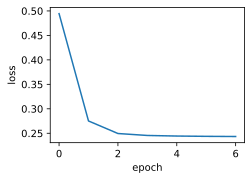

In [13]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

loss 0.242056, 0.500772 sec per epoch


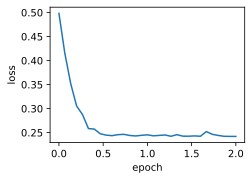

In [14]:
train_sgd(0.005, 1)

loss 0.281091, 0.061348 sec per epoch


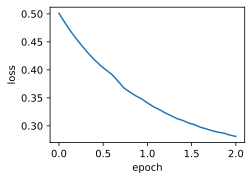

In [16]:
train_sgd(0.005, 10)

### 7.3.3 简洁实现

In [0]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels, batch_size=10, num_epochs=2):
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2 

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True
    )

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X).view(-1), y) / 2 
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())

    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.295023, 0.053357 sec per epoch


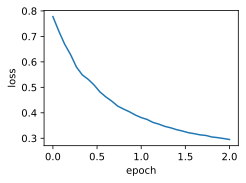

In [19]:
train_pytorch_ch7(optim.SGD, {'lr': 0.005}, features, labels, 10)